- **WMAP datasets**: https://lambda.gsfc.nasa.gov/product/map/dr3/maps_band_smth_r9_i_5yr_get.cfm

### Part 1: Data preprocessing

#### Import the modules

In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams["axes.unicode_minus"] = False
from astropy.io import fits

#### Read and write the FITS files

**A. Read FITS files and return data array and header**
 
-- **Parameters** --

1.file_name: string
- Name of the FITS file

2.data: float array
- Data array extracted from the FITS file
 
3.header: fits header
- Header of the FITS file

[Note]； We have specified to read only the second extension of the FITS.

**B. Write a 2D array (usually an image) to a FITS file**
 
-- **Parameters** --

1.file_name: string
- Name of the FITS file
 
2.data: float array
- 2D array to be written

3.header: FITS header
- Optional FITS header. A minimal header is created automatically if none is provided.


- Default: None

In [2]:
def readfits(file_name):
    hdulist = fits.open(file_name)
    
    # hdulist.info()
    data = hdulist[1].data 
    header = hdulist[1].header
    
    hdulist.close()
    
    return data, header

def writefits(file_name, data, header = None):
    hdu = fits.PrimaryHDU()
    hdu.data = np.array(data, dtype = np.float32)

    if header is not None:
        hdu.header = header
    
    hdu.writeto(file_name, overwrite = True)
    
    return None

#### Visualize the channel maps

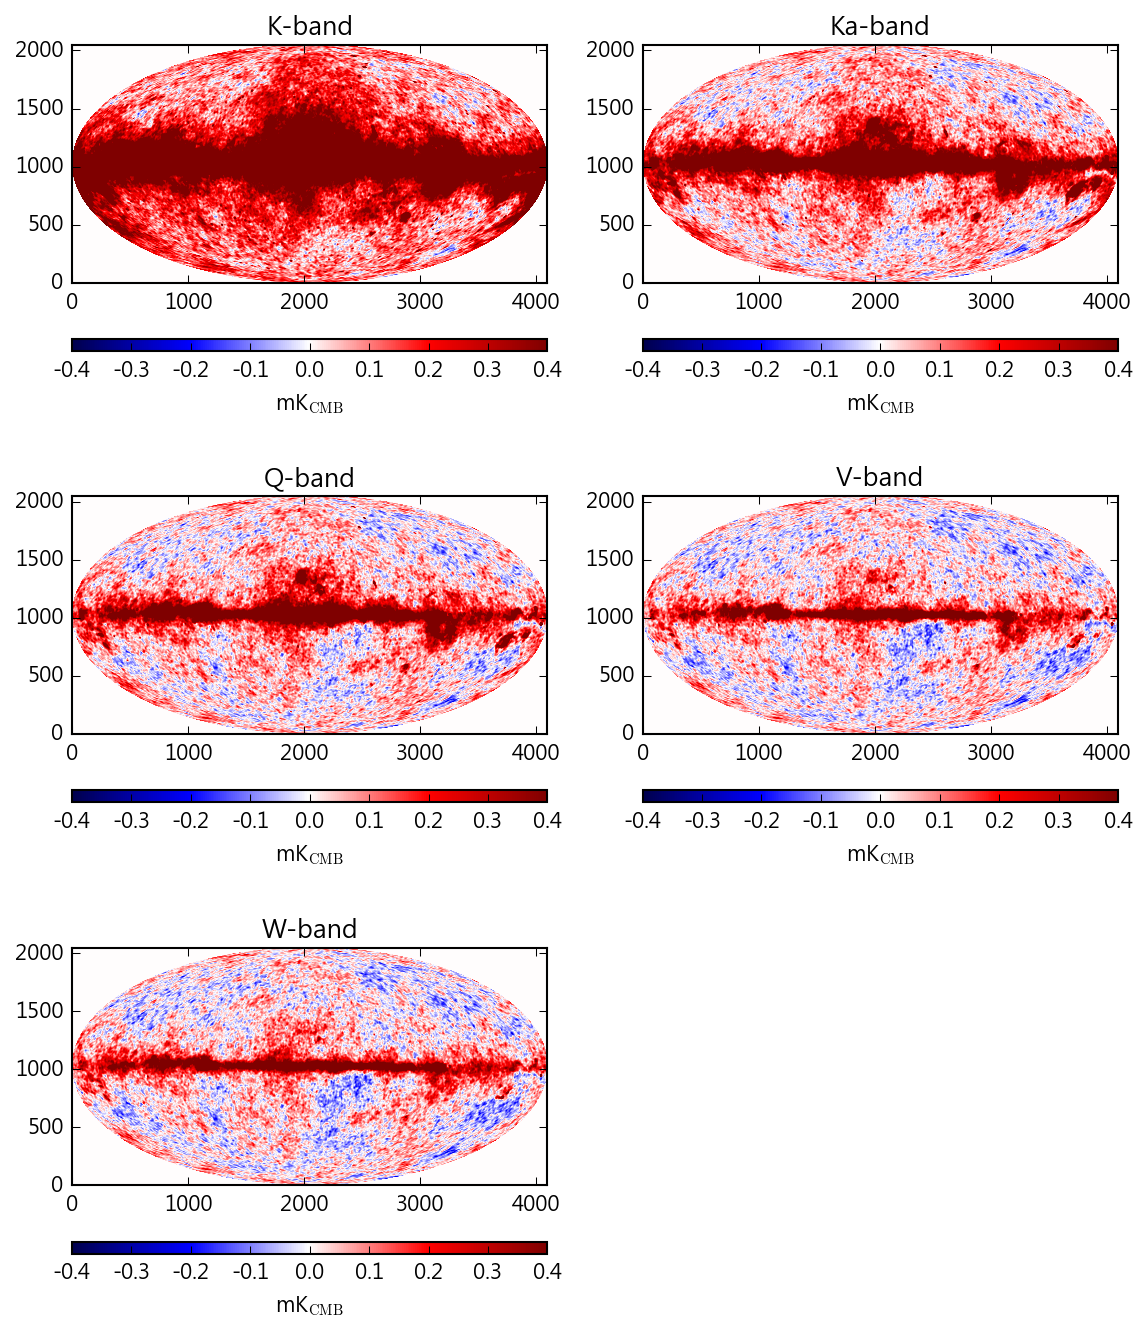

In [3]:
# Read all the channel maps (map units mK)
freq_ghz = [22.0, 25.9, 32.5, 49.1, 90.1]
bandname = ['K', 'Ka', 'Q', 'V', 'W']
data = []
map_path = r'C:\Users\user\Desktop\wmap_mollweide_channel_maps'

fig = plt.figure(figsize = (9, 11), dpi = 150)
for i in np.arange(5):
    plt.subplot(3, 2, i + 1)
    image, header = readfits(map_path+'\\'+'wmap_mollweide_band_smth_imap_r9_5yr_{0}_v3.fits'.format(bandname[i]))
    plt.imshow(image, cmap = "seismic", vmin = -0.4, vmax = 0.4, origin = "lower")
    plt.colorbar(label = r'mK$_\mathrm{CMB}$', orientation = 'horizontal', aspect = 40)
    plt.title(bandname[i] + "-band")
    data.append(image)

#### View the header infomation

In [4]:
header

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32 / Number of bits per data pixel                  
NAXIS   =                    2 / Number of data axes                            
NAXIS1  =                 4096 /                                                
NAXIS2  =                 2048 /                                                
PCOUNT  =                    0 / No Group Parameters                            
GCOUNT  =                    1 / One Data Group                                 
EXTNAME = 'TEMPERATURE'        /                                                
CTYPE1  = 'GLON-MOL'           / Coordinate Type                                
CTYPE2  = 'GLAT-MOL'           / Coordinate Type                                
EQUINOX =              2000.00 / Equinox of Ref. Coord.                         
CDELT1  =     -0.0791293637247 / Degrees / Pixel                                
CDELT2  =      0.07912936372

#### Make the data array 

In [5]:
data = np.array(data)
print(data.shape) 

(5, 2048, 4096)


### Part 2: Component Separation - Internal Linear Combination (ILC) method

#### Reshape the data

In [6]:
data_2D = np.reshape(data, (data.shape[0], data.shape[1] * data.shape[2]))
print('data_2D.shape = ', data_2D.shape)

data_2D.shape =  (5, 8388608)


####  Calculate the correlation coefficients between any two channels and visualize it

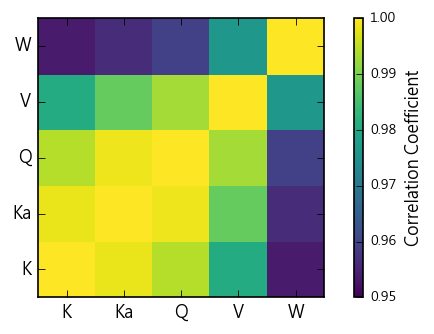

In [7]:
corr_coeff = np.corrcoef(data_2D)

fig = plt.figure(figsize = (4, 3), dpi = 120)
plt.pcolor(corr_coeff, cmap = "viridis", vmin = 0.95, vmax = 1)
plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5], ('K', 'Ka', 'Q', 'V', 'W'))
plt.yticks([0.5, 1.5, 2.5, 3.5, 4.5], ('K', 'Ka', 'Q', 'V', 'W'))
plt.tick_params(labelsize = 10)
cb = plt.colorbar(label = 'Correlation Coefficient', orientation = 'vertical',
                  ticks = [0.95, 0.96, 0.97, 0.98, 0.99, 1.00], shrink = 1, pad = 0.08, aspect = 30)
cb.ax.tick_params(labelsize = 8)
cb.ax.yaxis.label.set_font_properties(mpl.font_manager.FontProperties(size = 10))
plt.show()

#### Calculate the covariance matrix and its inverse matrix

In [8]:
cov_mat = np.cov(data_2D, bias = True)
print('cov_mat = ')
print(cov_mat)
print('--------------------------------------------------------------------')

cov_mat_inv = np.linalg.inv(cov_mat)
print('cov_mat_inv = ')
print(cov_mat_inv)

cov_mat = 
[[ 6.5270205   2.85809298  1.75299374  0.78483242  0.5666597 ]
 [ 2.85809298  1.25591899  0.77231008  0.34694326  0.24919952]
 [ 1.75299374  0.77231008  0.47609005  0.21472113  0.15397364]
 [ 0.78483242  0.34694326  0.21472113  0.09815634  0.07116823]
 [ 0.5666597   0.24919952  0.15397364  0.07116823  0.05409517]]
--------------------------------------------------------------------
cov_mat_inv = 
[[  282.5651377  -1234.22773999   911.5374133    304.03417358
   -268.77871055]
 [-1234.22773999  6500.27425052 -6483.81377472   710.47588327
    504.57444238]
 [  911.5374133  -6483.81377472  8777.35812636 -4133.28413141
    774.71683952]
 [  304.03417358   710.47588327 -4133.28413142  5678.31544871
  -2163.46476402]
 [ -268.77871055   504.57444238   774.71683952 -2163.46476402
   1150.75593009]]


#### Calculate the channel weights

In [9]:
weights = np.sum(cov_mat_inv, axis = 1)/np.sum(cov_mat_inv)
weights

array([-0.02091733, -0.01167029, -0.65927899,  1.7013004 , -0.00943379])

#### Calculate the estimation $s_{ILC}\ (p)$ and  reshape it to the original data shape

In [10]:
ILC = np.zeros([data_2D.shape[0], data_2D.shape[1]])
for i in range(data_2D.shape[0]):
    ILC[i] = weights.T[i] * data_2D[i]

ILC = np.sum(ILC, axis = 0)
ILC_pixel = np.reshape(ILC, (data.shape[1], data.shape[2]))
np.float32(ILC_pixel)

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

#### Plot CMB all-sky map

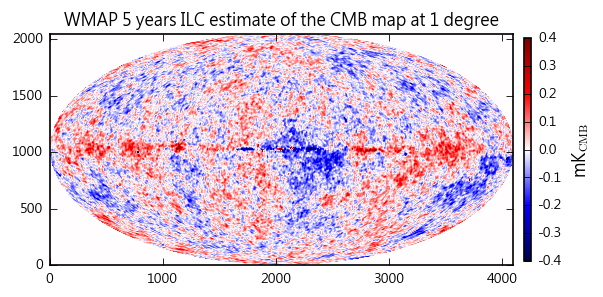

In [11]:
fig = plt.figure(figsize = (6, 4), dpi = 120)
plt.imshow(ILC_pixel, cmap = "seismic", vmin = -0.4, vmax = 0.4, origin = "lower")
cb = plt.colorbar(label = r'mK$_\mathrm{CMB}$', orientation = 'vertical', shrink = 0.6, pad = 0.02, aspect = 30)
plt.title("WMAP 5 years ILC estimate of the CMB map at 1 degree", fontsize = 10)
plt.tick_params(labelsize = 8)
cb.ax.tick_params(labelsize = 8)
cb.ax.yaxis.label.set_font_properties(mpl.font_manager.FontProperties(size = 10))
plt.show()

#### Reference:

- [CMB Data Analysis p.12-13](http://jstarck.free.fr/ChapterCMB2011.pdf)